<a href="https://colab.research.google.com/github/GabrielBMiranda/MacCormack/blob/main/MacCormack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# SUBSONIC-SUPERSONIC ISENTROPIC FLOW



**Quasi-One-Dimensional Nozzle Problem**: *Given $A, c_v$ and $R$, find $T, \rho$ and $V$, such that*

$\begin{equation}\tag{Continuity}
\frac{\partial(\rho A)}{\partial t}+\rho A \frac{\partial V}{\partial x}+\rho V \frac{\partial A}{\partial x}+V A \frac{\partial \rho}{\partial x}=0
\end{equation}$

$\begin{equation}\tag{Momentum}
\rho \frac{\partial V}{\partial t}+\rho V \frac{\partial V}{\partial x}=-R\left(\rho \frac{\partial T}{\partial x}+T \frac{\partial \rho}{\partial x}\right)
\end{equation}$

$\begin{equation}\tag{Energy}
\rho c_{v} \frac{\partial T}{\partial t}+\rho V c_{v} \frac{\partial T}{\partial x}=-\rho R T\left[\frac{\partial V}{\partial x}+V \frac{\partial(\ln A)}{\partial x}\right]
\end{equation}$

<figure>
<center>
<img src='https://github.com/GabrielBMiranda/MacCormack/blob/main/nozzle_white.png?raw=true', width='500' />
<figcaption>Nozzle Configuration</figcaption></center>
</figure>


## Dimensionless Problem
Lets define dimensionless variables to work with: first, let $L$ be the length of the nozzle, and $A^*$ the sonic throat area, we define 
$$
x^{\prime}=\frac{x}{L}, \quad A^{\prime}=\frac{A}{A^*}
$$
the dimensionless length and area respectively.

Having the speed of sound in the reservoir $a_{0}=\sqrt{\gamma R T_{0}}$ we also define the dimensionless time as
$$
\begin{aligned}
t^{\prime}=\frac{t}{\frac{L}{a_{0}}}
\end{aligned}
$$

Finally we define our dimensionless variables of interest, temperature, density and velocity, respectively as
$$
\begin{aligned}
T^{\prime}=\frac{T}{T_{0}}, \quad \rho^{\prime}=\frac{\rho}{\rho_{0}}, \quad V^{\prime}=\frac{V}{a_{0}}.
\end{aligned}
$$


With some algebric manipulation we can rewrite the problem as follows

$\begin{equation}\tag{Continuity}
\frac{\partial \rho^{\prime}}{\partial t^{\prime}}=-\rho \frac{\partial V^{\prime}}{\partial x^{\prime}}-\rho^{\prime} V^{\prime} \frac{\partial\left(\ln A^{\prime}\right)}{\partial x^{\prime}}-V^{\prime} \frac{\partial \rho^{\prime}}{\partial x^{\prime}}
\end{equation}$

$\begin{equation}\tag{Momentum}
\frac{\partial V^{\prime}}{\partial t^{\prime}}=-V^{\prime} \frac{\partial V^{\prime}}{\partial x^{\prime}}-\frac{1}{\gamma}\left(\frac{\partial T^{\prime}}{\partial x^{\prime}}+\frac{T^{\prime}}{\rho^{\prime}} \frac{\partial \rho^{\prime}}{\partial x^{\prime}}\right)
\end{equation}$

$\begin{equation}\tag{Energy}
\frac{\partial T^{\prime}}{\partial t^{\prime}}=-V^{\prime} \frac{\partial T^{\prime}}{\partial x^{\prime}}-(\gamma-1) T^{\prime}\left[\frac{\partial V^{\prime}}{\partial x^{\prime}}+V^{\prime} \frac{\partial\left(\ln A^{\prime}\right)}{\partial x^{\prime}}\right]
\end{equation}$

This equations' system will be solved numerically by Mac-Cormack's explicit technique given the initial and boundary conditions to suplement the problem.

## Initial Conditions (*and Global Variables*)

Now we set the conditions to start our domain

In [2]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn') 
plt.rcParams['mathtext.fontset'] = 'stix'
plt.rcParams['font.family'] = 'STIXGeneral'
from copy import copy

tol = 1e-4
dx = 0.1
Omega = np.arange(0,3+dx,dx)    # add dx in end of domain to include last point   # index array of unknown points
C = 0.5

gamma = 1.4

def Area(x):
    return 1 + 2.2*(x-1.5)**2

# The minimum for the area function is the nozzle point, ie x = 1.5 -> M = 1

# Initial Condition
def p_init(x):
    return 1 - 0.3146*x

def T_init(x):
    return 1 - 0.2314*x

def V_init(x):
    return (0.1 + 1.09*x)*np.sqrt(T_init(x))


### Forward Diff

$$
\begin{array}{l}
\left(\frac{\partial \rho}{\partial t}\right)_{i}^{t}=-\rho_{i}^{t} \frac{V_{i+1}^{t}-V_{i}^{t}}{\Delta x}-\rho_{i}^{t} V_{i}^{t} \frac{\ln A_{i+1}-\ln A_{i}}{\Delta x}-V_{i}^{t} \frac{\rho_{i+1}^{t}-\rho_{i}^{t}}{\Delta x} \\
\left(\frac{\partial V}{\partial t}\right)_{i}^{t}=-V_{i}^{t} \frac{V_{i+1}^{t}-V_{i}^{t}}{\Delta x}-\frac{1}{\gamma}\left(\frac{T_{i+1}^{t}-T_{i}^{t}}{\Delta x}+\frac{T_{i}^{t}}{\rho_{i}^{t}} \frac{\rho_{i+1}^{t}-\rho_{i}^{t}}{\Delta x}\right) \\
\left(\frac{\partial T}{\partial t}\right)_{i}^{t}=-V_{i}^{t} \frac{T_{i+1}^{t}-T_{i}^{t}}{\Delta x}-(\gamma-1) T_{i}^{t}\left(\frac{V_{i+1}^{t}-V_{i}^{t}}{\Delta x}+V_{i}^{t} \frac{\ln A_{i+1}-\ln A_{i}}{\Delta x}\right)
\end{array}
$$


In [3]:
def dp_dt(i):
    j = i + 1
    val =   - p[i]*( V[j] - V[i] )  \
            - p[i]*V[i] * ( np.log(A[j]/A[i]) ) \
            - V[i]*( p[j] - p[i] )
    return val/dx

def dV_dt(i):
    j = i + 1  
    val =   - V[i] * (V[j] - V[i]) \
            -(T[j] - T[i] + T[i]/p[i] * ( p[j]-p[i]) )/gamma
    return val/dx

def dT_dt(i):
    j = i + 1
    val =   - V[i]*(T[j]-T[i]) \
            - (gamma - 1) * T[i] * (
                 V[j] - V[i] + V[i]*( np.log(A[j]/A[i]) ) )   
    return val/dx

### Backward Diff

$$
\begin{array}{l}
\left(\frac{\overline{\partial \rho}}{\partial t}\right)_{i}^{t+\Delta t}=-\bar{\rho}_{i}^{t+\Delta t} \frac{\bar{V}_{i}^{t+\Delta t}-\bar{V}_{i-1}^{t+\Delta t}}{\Delta x}-\bar{\rho}_{i}^{t+\Delta t} \bar{V}_{i}^{t+\Delta t} \frac{\ln A_{i}-\ln A_{i-1}}{\Delta x}-\bar{V}_{i}^{t+\Delta t} \frac{\bar{\rho}_{i}^{t+\Delta t}-\bar{\rho}_{i-1}^{t+\Delta t}}{\Delta x} \\
\left(\frac{\overline{\partial V}}{\partial t}\right)_{i}^{t+\Delta t}=-\bar{V}_{i}^{t+\Delta t} \frac{\bar{V}_{i}^{t+\Delta t}-\bar{V}_{i-1}^{t+\Delta t}}{\Delta x} -
 \frac{1}{\gamma}\left(\frac{\bar{T}_{i}^{t+\Delta t}-\bar{T}_{i-1}^{t+\Delta t}}{\Delta x}+\frac{\bar{T}_{i}^{t+\Delta t}}{\bar{\rho}_{i}^{t+\Delta t}} \frac{\bar{\rho}_{i}^{t+\Delta t}-\bar{\rho}_{i-1}^{t+\Delta t}}{\Delta x}\right) \\
\left(\frac{\overline{\partial T}}{\partial t}\right)_{i}^{t+\Delta t}=-\bar{V}_{i}^{t+\Delta t} \frac{\bar{T}_{i}^{t+\Delta t}-\bar{T}_{i-1}^{t+\Delta t}}{\Delta x} -
(\gamma-1) \bar{T}_{i}^{t+\Delta t} \times\left(\frac{\bar{V}_{i}^{t+\Delta t}-\bar{V}_{i-1}^{t+\Delta t}}{\Delta x}+\bar{V}_{i}^{t+\Delta t} \frac{\ln A_{i}-\ln A_{i-1}}{\Delta x}\right)
\end{array}
$$

In [4]:
def dp_dt_(i):
    j = i - 1
    val =   - p_[i]*( V_[i] - V_[j] )  \
            - p_[i]*V_[i] * ( np.log(A[i]/A[j]) ) \
            - V_[i]*( p_[i] - p_[j] )
    return val/dx

def dV_dt_(i):
    j = i - 1  
    val =   - V_[i] * (V_[i] - V_[j]) \
            -(T_[i] - T_[j] + T_[i]/p_[i] * (p_[i]-p_[j]) )/gamma
    return val/dx

def dT_dt_(i):
    j = i - 1
    val =   - V_[i]*(T_[i]-T_[j]) \
            - (gamma - 1) * T_[i] * (
                 V_[i] - V_[j] + V_[i]*( np.log(A[i]/A[j]) ) )   
    return val/dx

Where
$$
\begin{aligned}
\bar{\rho}_{i}^{t+\Delta t} &=\rho_{i}^{t}+\left(\frac{\partial \rho}{\partial t}\right)_{i}^{t} \Delta t \\
\bar{V}_{i}^{t+\Delta t} &=V_{i}^{t}+\left(\frac{\partial V}{\partial t}\right)_{i}^{t} \Delta t \\
\bar{T}_{i}^{t+\Delta t} &=T_{i}^{t}+\left(\frac{\partial T}{\partial t}\right)_{i}^{t} \Delta t
\end{aligned}
$$
and we define time step in each step by the criterion:
$$
\Delta t=\operatorname{min}\left(\Delta t_{1}^{t}, \Delta t_{2}^{t}, \ldots, \Delta t_{i}^{t}, \ldots, \Delta t_{N}^{t}\right)
$$
where each $\Delta t_{i}$ is given by the CFL condition:
$$
\Delta t_i = C \frac{\Delta x}{\sqrt{T_i}+V_i}
$$

## The Approximation
Then we can do the prediction. With the forward and bacward differentiation, called by the author as prediction and correction, we take the average as follows
$$
\begin{array}{l}
\left(\frac{\partial \rho}{\partial t}\right)_{a v}=0.5\left[\left(\frac{\partial \rho}{\partial t}\right)_{i}^{t}+\left(\frac{\overline{\partial \rho}}{\partial t}\right)_{i}^{t+\Delta t}\right] \\
\left(\frac{\partial V}{\partial t}\right)_{\text {av }}=0.5\left[\left(\frac{\partial V}{\partial t}\right)_{i}^{t}+\left(\frac{\overline{\partial V}}{\partial t}\right)_{i}^{t+\Delta t}\right] \\
\left(\frac{\partial T}{\partial t}\right)_{a v}=0.5\left[\left(\frac{\partial T}{\partial t}\right)_{i}^{t}+\left(\frac{\overline{\partial T}}{\partial t}\right)_{i}^{t+\Delta t}\right]
\end{array}
$$

In [5]:
def plot_res( dp_dt_av, dV_dt_av, it ):

    plt.plot(Omega[1:-1],np.log(np.abs(dp_dt_av)))
    plt.xlabel(r'$x$')
    plt.ylabel(r'$\ln\frac{\partial\rho}{\partial t}$', rotation=0, fontsize=15)
    plt.title(r'Variação da densidade no instante $t={:.2f}$'.format(it*dt))
    plt.savefig('output/logrho_'+str(it)+'.png', dpi=100)
    plt.close()

    plt.plot(Omega[1:-1],np.log(np.abs(dV_dt_av)))
    plt.xlabel(r'$x$')
    plt.ylabel(r'$\ln\frac{\partial V}{\partial t}$', rotation=0, fontsize=15)
    plt.title(r'Variação da velocidade no instante $t={:.2f}$'.format(it*dt))
    plt.savefig('output/logvel_'+str(it)+'.png', dpi=100)
    plt.close()

def plot_vars( p, T, V, it ):

    plt.plot(Omega,p)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$\rho$', rotation=0, fontsize=15)
    plt.title(r'Densidade no instante $t={:.2f}$'.format(it*dt))
    plt.savefig('output/vars/rho_'+str(it)+'.png', dpi=100)
    plt.close()

    plt.plot(Omega,T)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$T$', rotation=0, fontsize=15)
    plt.title(r'Temperatura no instante $t={:.2f}$'.format(it*dt))
    plt.savefig('output/vars/tem_'+str(it)+'.png', dpi=100)
    plt.close()

    plt.plot(Omega,V)
    plt.xlabel(r'$x$')
    plt.ylabel(r'$V$', rotation=0, fontsize=15)
    plt.title(r'Velocidade no instante $t={:.2f}$'.format(it*dt))
    plt.savefig('output/vars/vel_'+str(it)+'.png', dpi=100)
    plt.close()


def MacCormack(Omega, courant):
    nel = len(Omega)
    indices = np.array([i for i in range(nel)])[1:-1]
    
    C = courant
    global A
    A = Area(Omega)
    global p
    p = p_init(Omega)
    global T
    T = T_init(Omega)
    global V
    V = V_init(Omega)

    # for i in range(15):
    global p_
    global T_
    global V_
    it = 0
    while(True):
        it += 1
        # aux vars for prediction step
        p_ = copy(p)
        T_ = copy(T)
        V_ = copy(V)

        dt = np.min(C * dx / (np.sqrt(T) + V))

        # PREDICTOR
        p_[1:-1] = p[1:-1] + dp_dt(indices) * dt
        V_[1:-1] = V[1:-1] + dV_dt(indices) * dt
        T_[1:-1] = T[1:-1] + dT_dt(indices) * dt

        # 
        dp_dt_av = 0.5*( dp_dt(indices) + dp_dt_(indices) )
        dV_dt_av = 0.5*( dV_dt(indices) + dV_dt_(indices) )
        dT_dt_av = 0.5*( dT_dt(indices) + dT_dt_(indices) )

        # CORRECTOR
        p[1:-1] = p[1:-1] + dp_dt_av * dt
        V[1:-1] = V[1:-1] + dV_dt_av * dt
        T[1:-1] = T[1:-1] + dT_dt_av * dt

        criteria = np.max( np.abs(np.concatenate((dp_dt_av,dV_dt_av,dT_dt_av))) )
        if(criteria < tol):
            break

        # Boundary Conditions
        p[ 0] = 1
        V[ 0] = 2*V[1] - V[2]
        T[ 0] = 1

        p[-1] = 2*p[-2] - p[-3]
        V[-1] = 2*V[-2] - V[-3]
        T[-1] = 2*T[-2] - T[-3]

        # Plot the results in the atual step
        # plot_res( dp_dt_av, dV_dt_av, it )
        # plot_vars( p, T, V, it )
    
courant = 0.5
dx = 0.1
Omega = np.arange(0,3+dx,dx)  
nel = len(Omega)
MacCormack(Omega, courant)
            

---
### Generate animations (*Run locally only*)
---

In [7]:
# import imageio
# images1 = []
# images2 = []
# images3 = []
# for k in range(1,871):
#     images1.append(imageio.imread('output/vars/rho_'+str(k)+'.png'))
#     images2.append(imageio.imread('output/vars/tem_'+str(k)+'.png'))
#     images3.append(imageio.imread('output/vars/vel_'+str(k)+'.png'))
# imageio.mimsave('output/vars/_rho_t.gif', images1)
# imageio.mimsave('output/vars/_tem_t.gif', images2)
# imageio.mimsave('output/vars/_vel_t.gif', images3)

Approximations for $\rho, V$ and $T$ respectively, until convergence to steady state:

<table><tr>
<td> <img src="https://github.com/GabrielBMiranda/MacCormack/blob/main/_rho_t.gif?raw=true" width="400" align="center"> </td>
<td> <img src="https://github.com/GabrielBMiranda/MacCormack/blob/main/_vel_t.gif?raw=true" width="400" align="center"> </td>
<td> <img src="https://github.com/GabrielBMiranda/MacCormack/blob/main/_tem_t.gif?raw=true" width="400" align="center"> </td>
</tr></table>

In [ ]:
# # !convert -delay  1 -loop 0 output/300/rho_*.png rho.gif
# # !convert -delay  1 -loop 0 output/300/vel_*.png vel.gif

# import imageio
# images1 = []
# images2 = []
# for k in range(1,301):
#     images1.append(imageio.imread('output/rho_'+str(k)+'.png'))
#     images2.append(imageio.imread('output/vel_'+str(k)+'.png'))
# imageio.mimsave('rho_1.gif', images1)
# imageio.mimsave('vel_1.gif', images2)

# images1 = []
# images2 = []
# for k in range(301,601):
#     images1.append(imageio.imread('output/rho_'+str(k)+'.png'))
#     images2.append(imageio.imread('output/vel_'+str(k)+'.png'))
# imageio.mimsave('rho_2.gif', images1)
# imageio.mimsave('vel_2.gif', images2)

# images1 = []
# images2 = []
# for k in range(601,871):
#     images1.append(imageio.imread('output/rho_'+str(k)+'.png'))
#     images2.append(imageio.imread('output/vel_'+str(k)+'.png'))
# imageio.mimsave('rho_3.gif', images1)
# imageio.mimsave('vel_3.gif', images2)

## Residu

- Step 1 to 300:
<table><tr>
<td> <img src="https://github.com/GabrielBMiranda/MacCormack/blob/main/rho_1.gif?raw=true" width="500" align="center"> </td>
<td> <img src="https://github.com/GabrielBMiranda/MacCormack/blob/main/vel_1.gif?raw=true" width="500" align="center"> </td>
</tr></table>

- Step 300 to 600:
<table><tr>
<td> <img src="https://github.com/GabrielBMiranda/MacCormack/blob/main/rho_2.gif?raw=true" width="500" align="center"> </td>
<td> <img src="https://github.com/GabrielBMiranda/MacCormack/blob/main/vel_2.gif?raw=true" width="500" align="center"> </td>
</tr></table>

- Step 600 to 824:
<table><tr>
<td> <img src="https://github.com/GabrielBMiranda/MacCormack/blob/main/rho_3.gif?raw=true" width="500" align="center"> </td>
<td> <img src="https://github.com/GabrielBMiranda/MacCormack/blob/main/vel_3.gif?raw=true" width="500" align="center"> </td>
</tr></table>

### Exact Solutions on the Nozzle.

Having the analytical solution given by
$$
\begin{aligned}
\rho^{\prime} = \frac{\rho}{\rho_{0}} &= \left(1+\frac{\gamma-1}{2} M^{2}\right)^{-1 /(\gamma-1)} \\
T^{\prime} = \frac{T}{T_{0}} &= \left(1+\frac{\gamma-1}{2} M^{2}\right)^{-1}
\end{aligned}
$$
where $M$ is the Mach number, given by
$$
M \approx 
\left\{\begin{array}{l}
    \left.\begin{array}{ll}
    \frac{1+0.27\left(A / A^{*}\right)^{-2}}{1.728 A / A^{*}}, & 1.34<\frac{A}{A^{*}}<\infty \\
    1-0.88\left(\ln \frac{A}{A^{*}}\right)^{0,45}, & 1.0<\frac{A}{A^{*}}<1.34
    \end{array}\right\} \\
    \left.\begin{array}{ll}
    1+1.2\left(\frac{A}{A^{*}}-1\right)^{1 / 2}, & 1.0<\frac{A}{A^{*}}<2.9 \\
    \left[216 \frac{A}{A^{*}}-254\left(\frac{A}{A^{*}}\right)^{2 / 3}\right]^{1 / 5}, & 2.9<\frac{A}{A^{*}}<\infty
    \end{array}\right\}
\end{array}\right.
$$
We can now evaluate the approximation on the domain comparing it with the exact solution. 

In [8]:
def exact_M(x):
    A = Area(x)
    M = np.zeros(x.size)
    for i in range(x.size):
        if(x[i] < 1.5):
            if (A[i] > 1.34):
                M[i] = (1 + 0.27*A[i]**(-2))/(1.728*A[i])
            else:
                M[i] = 1 - 0.88 * np.log(A[i])**0.45
        else:
            if (A[i] > 2.9):
                M[i] = (216*A[i] - 254*A[i]**(2/3))**(1/5)
            else:
                M[i] = 1 + 1.2*(A[i]-1)**(1/2)
    return M

def exact_p(x):
    return (1+(gamma-1)/2*exact_M(x)**2)**(-1/(gamma-1) )

def exact_T(x):
    return (1+(gamma-1)/2*exact_M(x)**2)**(-1)


## Plot Comparisons

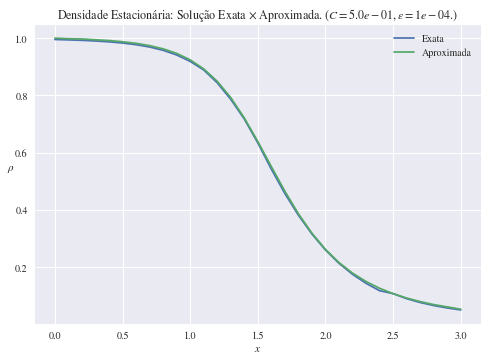

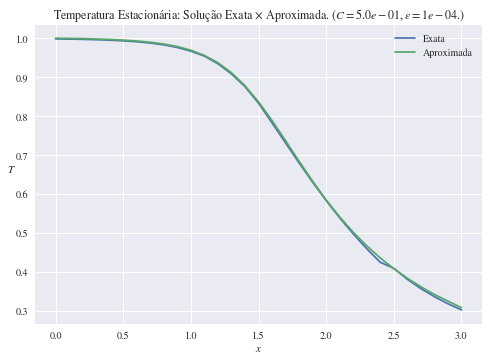

In [9]:
plt.plot(Omega,exact_p(Omega), label='Exata')
plt.plot(Omega,p, label='Aproximada')
plt.xlabel(r'$x$')
plt.ylabel(r'$\rho$', rotation=0)
plt.title(r'Densidade Estacionária: Solução Exata $\times$ Aproximada. ($C = {:.1e}, \epsilon = {:.0e}$.)'.format(courant, tol))
plt.legend(loc='best')
# plt.savefig('imgs/__rho_stat-nel'+str(nel)+'.png', dpi=100)
plt.show()
plt.close()

plt.plot(Omega,exact_T(Omega), label='Exata')
plt.plot(Omega,T, label='Aproximada')
plt.xlabel(r'$x$')
plt.ylabel(r'$T$', rotation=0)
plt.title(r'Temperatura Estacionária: Solução Exata $\times$ Aproximada. ($C = {:.1e}, \epsilon = {:.0e}$.)'.format(courant, tol))
plt.legend(loc='best')
# plt.savefig('imgs/__tem_stat-nel'+str(nel)+'.png', dpi=100)
plt.show()
plt.close()

## Testing other meshes and Courant values.

To see the plot for different just choose other values for `courant` and `dx` and rerun the code in section **Plot Comparisons**.

In [ ]:
courant = 0.5
dx = 0.01
Omega = np.arange(0,3+dx,dx)  
nel = len(Omega)
MacCormack(Omega, courant)

In [ ]:
courant = 1
dx = 0.01
Omega = np.arange(0,3+dx,dx)  
nel = len(Omega)
MacCormack(Omega, courant)

In [ ]:
courant = 0.75
dx = 0.05
Omega = np.arange(0,3+dx,dx)  
nel = len(Omega)
MacCormack(Omega, courant)

For more details see Section 7 of 

[Anderson, J. D., & Wendt, J. (1995). Computational fluid dynamics (Vol. 206, p. 332). New York: McGraw-Hill.](https://link.springer.com/book/10.1007%2F978-3-540-85056-4)
